In [1]:
from face_detector import YoloDetector
import numpy as np
from PIL import Image
import torchvision.transforms.functional as TF
import os
import time
from tqdm.notebook import tqdm, trange
import torch
import copy
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
%matplotlib inline
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


In [36]:
from cv2 import normalize


class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, csv_path, images_folder, transform = None, normalize = True, max_size=None):
        super().__init__()
        self.df = pd.read_csv(csv_path)
        self.images_folder = images_folder
        self.transform = transform
        self.normal = normalize
        self.class2index = {}
        for i in range(1,10):
            self.class2index["c" + str(i)] = 1
        self.class2index["c0"] = 0
        self.model = model = YoloDetector(target_size=720,gpu=-1,min_face=90)
        self.data = {'image':[], 'label':[], 'orgimg':[]}
        length = min(max_size, len(self.df.index)) if max_size != None else len(self.df.index)
        for i in range(length):
            filename = self.df.iloc[i]["img"]
            classname = self.df.iloc[i]["classname"]
            label = self.class2index[classname]
            #print(os.path.join(self.images_folder, classname, filename))
            image = Image.open(os.path.join(self.images_folder, classname, filename))
            orgimg = np.array(image)
            bboxes,points = self.model.predict(orgimg)
            if len(bboxes[0]) == 0:
                continue
            coor = self.bigger(bboxes[0])
            imgten = torch.from_numpy(orgimg)
            #print(imgten.size())
            #print(coor[3] - coor[1], " ", coor[2] - coor[0])
            image = TF.crop(image, coor[1], coor[0], coor[3] - coor[1], coor[2] - coor[0])
            self.data['image'].append(image)
            self.data['label'].append(label)
            self.data['orgimg'].append(orgimg)
    def __len__(self):
        return len(self.data['image'])
    
    def bigger(self, bboxes):
        index = None
        maxArea = 0 
        for i,box in enumerate(bboxes):
            area = (box[2] - box[0]) * (box[3] - box[1])
            if(area > maxArea):
                index = i
                maxArea = area
        return bboxes[index]
        
    def __getitem__(self, index):
        image,label,orgimg = self.data['image'][index], self.data['label'][index], self.data['orgimg'][index]
        if self.transform != None:
            image = self.transform(image) 
        if normalize:
            mean, std = image.mean([1,2]), image.std([1, 2])
            # print("mean: ", mean)
            # print("std: ", std)
            image = transforms.Normalize(mean, std)(image)
        return image, label, orgimg

    def rawImage(self, index):
        filename = self.df.iloc[index]["img"]
        classname = self.df.iloc[index]["classname"]
        image = Image.open(os.path.join(self.images_folder, classname, filename))
        return image  

In [37]:
test_dts = CustomDataset("driver_imgs_list.csv", "imgs/train/" 
        ,transform = transforms.Compose([
            transforms.Resize([224,224]),
            transforms.ColorJitter(),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ]), normalize = True, max_size=100)

-1
/Users/e2318573/Documents/Projects/test/weights/yolov5n_state_dict.pt


In [71]:
print(test_dts[0][2])

[[[ 27  28  22]
  [ 28  29  23]
  [ 28  29  23]
  ...
  [255 253 255]
  [254 253 255]
  [254 253 255]]

 [[ 27  28  22]
  [ 28  29  23]
  [ 28  29  23]
  ...
  [255 253 255]
  [254 253 255]
  [254 253 255]]

 [[ 26  29  22]
  [ 27  30  23]
  [ 27  30  23]
  ...
  [255 253 255]
  [255 253 255]
  [255 253 255]]

 ...

 [[  9   9   1]
  [  8   9   1]
  [  8   9   1]
  ...
  [ 24  20  19]
  [ 24  20  19]
  [ 23  19  18]]

 [[  8   9   3]
  [  7  10   3]
  [  7  10   3]
  ...
  [ 43  37  37]
  [ 42  36  36]
  [ 39  33  33]]

 [[  7  10   3]
  [  7  10   3]
  [  7  10   3]
  ...
  [ 56  50  50]
  [ 55  49  49]
  [ 50  44  44]]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224])
mean:  tensor(-9.73137e-09)
std:  tensor(0.99999)


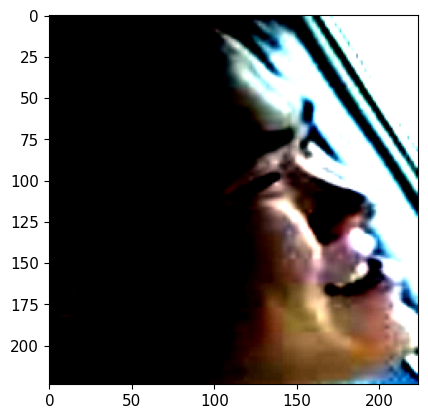

In [45]:
image, label, orgimg = test_dts[90]
raw_img = test_dts.rawImage(50)
print(image.size())
print("mean: ", image.mean([0,1,2]))
print("std: ", image.std([0,1,2]))
#plt.imshow(raw_img)
image_normal = np.array(orgimg)
image = image.permute([1,2, 0])
plt.imshow(image)
plt.show()

In [95]:
class MyClassifier(nn.Module):
    def __init__(self, device):
        super().__init__()
        pretrained = models.vgg16(pretrained = True)
        pretrained.classifier.add_module('7',nn.Linear(1000,1))
        pretrained.classifier.add_module('8',nn.Sigmoid())
        self.layers = nn.ModuleList()
        self.layers.append(pretrained.features)
        self.layers.append(pretrained.avgpool)
        self.layers.append(nn.Flatten(end_dim = -1,start_dim=1))
        self.layers.append(pretrained.classifier)
    def forward(self,x):
        for layer in self.layers:
            x = layer(x)
        return x

In [96]:
model = MyClassifier(device)
model.eval()

/Users/e2318573/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Users/e2318573/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MyClassifier(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      

In [92]:
NUM_BATCH= 4

In [98]:
train_loader = DataLoader(test_dts, batch_size=NUM_BATCH, shuffle=True)
for i,(imgs, label, orgimg) in enumerate(train_loader):
    print(imgs.size())
    print(model(imgs))

torch.Size([4, 3, 224, 224])
tensor([[0.26570],
        [0.33967],
        [0.26649],
        [0.33189]], grad_fn=<SigmoidBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.53978],
        [0.33107],
        [0.19773],
        [0.20746]], grad_fn=<SigmoidBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.23702],
        [0.38061],
        [0.52627],
        [0.57765]], grad_fn=<SigmoidBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.46245],
        [0.16316],
        [0.50319],
        [0.49549]], grad_fn=<SigmoidBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.49686],
        [0.45591],
        [0.25091],
        [0.35890]], grad_fn=<SigmoidBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.38663],
        [0.32112],
        [0.30563],
        [0.35606]], grad_fn=<SigmoidBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.33810],
        [0.40463],
        [0.44299],
        [0.26685]], grad_fn=<SigmoidBackward0>)
torch.Size([4, 3, 224, 224])
tensor([[0.37744],
        [0.190

In [57]:
model.train()
    

MyClassifier(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      

In [90]:
img, label, orgimg = test_dts[0]
print(model(img))

tensor([0.30703], grad_fn=<SigmoidBackward0>)


In [109]:

criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [146]:
def train_simple(model, device, dataset,num_epochs=5):
    model.to(device)
    since = time.time()
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        for phase in ["train", "eval"]:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            running_corrects = 0
            for i, (inputs, labels, orgimg) in enumerate(train_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    pred = torch.round(outputs)
                    pred = torch.squeeze(pred)
                    print(outputs[:,0])
                    print(labels)
                    loss = criterion(outputs[:,0].type(torch.float32), labels.type(torch.float32))
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                print(pred)
                running_corrects += torch.sum(torch.logical_and(pred.type(torch.float32), labels))
            if phase == 'train':
                scheduler.step()
            epoch_loss = running_loss / 100
            epoch_acc = running_corrects.double() / 100
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(time_elapsed //3600, 
        time_elapsed // 60, time_elapsed % 60))
    return model


In [147]:
train_simple(model, device, test_dts)

Epoch 0/4
----------
tensor([1.00000, 0.99914, 0.99808, 1.00000], grad_fn=<SelectBackward0>)
tensor([0, 0, 1, 0])
tensor([1., 1., 1., 1.], grad_fn=<SqueezeBackward0>)
tensor([1.00000, 0.99998, 1.00000, 0.99998], grad_fn=<SelectBackward0>)
tensor([0, 0, 0, 0])
tensor([1., 1., 1., 1.], grad_fn=<SqueezeBackward0>)
tensor([1.00000, 1.00000, 1.00000, 1.00000], grad_fn=<SelectBackward0>)
tensor([0, 0, 0, 0])
tensor([1., 1., 1., 1.], grad_fn=<SqueezeBackward0>)
tensor([1.00000, 1.00000, 1.00000, 1.00000], grad_fn=<SelectBackward0>)
tensor([1, 0, 0, 0])
tensor([1., 1., 1., 1.], grad_fn=<SqueezeBackward0>)
tensor([1.00000, 0.99999, 1.00000, 1.00000], grad_fn=<SelectBackward0>)
tensor([1, 1, 0, 0])
tensor([1., 1., 1., 1.], grad_fn=<SqueezeBackward0>)
tensor([0.99999, 1.00000, 0.99999, 1.00000], grad_fn=<SelectBackward0>)
tensor([1, 0, 0, 1])
tensor([1., 1., 1., 1.], grad_fn=<SqueezeBackward0>)
tensor([0.99999, 1.00000, 1.00000, 1.00000], grad_fn=<SelectBackward0>)
tensor([0, 1, 0, 0])
tensor([1.

KeyboardInterrupt: 